## GAN with one sequence as input

С применением этой модели возникли сложности. Налицо фундаментальная ошибка - сомнительная эффективность работы с one hot векторами на входе. Более логичным выглядит преобразование сырой последовательности эмбеддингом и последующие свертки (как в автоэнкодере), но структура GAN требует, чтобы выход генератора и вход дискриминатора были одного размера. Выход генератора - это всегда вероятности. Функции аргмакса или слои пуллинга убивают градиент, поэтому как использовать эмбеддинги в одной сети я так и не придумал. Поэтому на вход подается так же one hot вектор.

Также, при использовании того же подхода, что и в автоэнкодере (конкатенация нот и длительностей, см. gan.ipynb), возникла ситуация с переобучением выхода длительностей, из-за чего генерировались самые редкие длительности - целые и дольше, и каждая композиция из всего 128 нот длилась 5-10 минут. Это неприемлемо, поэтому я так же пробовал обучать отдельные сети для нот и последовательностей. Усугубляет ситуацию батч-нормализация, поэтому ее не использую. Подбирать параметры сети то еще удовольствие, поэтому для быстрого приемлемого результата попробовал использовать длительности, сгенерированные простой марковской цепью.

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
import sys
sys.path.append('src/')
from models.ganos import MusicGAN
from save_midi import save_notes_and_durations
from preprocess import parse_files_to_sequences, limit_uniq_notes, get_dictionaries

In [2]:
folderpath = "tabs/"
track_name = 'guitar'

In [3]:
notes, durations = parse_files_to_sequences(folderpath, track_name, True)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
len(notes), len(set(notes))

(16050, 310)

In [5]:
notes, durations = limit_uniq_notes(notes, durations, 150)

In [6]:
note_dictionary, inv_note_dictionary, notes_to_int, \
duration_dictionary, inv_dur_dictionary, durations_to_int = get_dictionaries(notes, durations)

In [7]:
def prepare_sequences(notes, durations, length, step, n_notes, n_durations):
    batch_size = 32
    note_sequences = []
    dur_sequences = []
    for i in range(0, len(notes) - length, step):
        note_sequences.append(notes[i: i + length])
        dur_sequences.append(durations[i: i + length])
    
    note_sequences = np.array(note_sequences)
    dur_sequences = np.array(dur_sequences)
    
    length = (len(note_sequences) // batch_size) * batch_size
    indicies = np.arange(length)
    np.random.shuffle(indicies)
    
    note_targets = to_categorical(note_sequences[indicies], n_notes)
    note_targets = np.where(note_targets == 0, -1, note_targets)
    dur_targets = to_categorical(dur_sequences[indicies], n_durations)
    dur_targets = np.where(dur_targets == 0, -1, dur_targets)
    targets = [note_targets, dur_targets]
    return targets

In [8]:
X = prepare_sequences(notes_to_int, durations_to_int, 128, 1, len(note_dictionary), len(duration_dictionary))
X[0].shape

(15456, 128, 150)

In [9]:
X[1].shape

(15456, 128, 32)

In [76]:
model_notes = MusicGAN(
    n_notes=X[0].shape[-1],
    input_dim=X[0].shape[1],
    kernel_size=32,
    discriminator_filters=[128, 64, 32, 16],
    discriminator_strides=[1, 2, 2, 1],
    generator_filters=[16, 32, 64, 128],
    generator_strides=[1, 2, 2, 1],
    z_dim=2,
    learning_rate=0.0005,
    use_batch_norm=False
)

model_durations = MusicGAN(
    n_notes=X[1].shape[-1],
    input_dim=X[1].shape[1],
    kernel_size=32,
    discriminator_filters=[32, 32, 16, 8],
    discriminator_strides=[1, 2, 2, 1],
    generator_filters=[8, 16, 32, 32],
    generator_strides=[1, 2, 2, 1],
    z_dim=2,
    learning_rate=0.0005,
    use_batch_norm=False
)

In [77]:
model_notes.train(X[0], 32, 101)

0 epoch. discriminator losses: real - 0.7180397510528564, fake = 0.6938167810440063,                 Generator loss - 0.692812979221344
1 epoch. discriminator losses: real - 0.11529772728681564, fake = 0.6961373090744019,                 Generator loss - 0.6886675357818604
2 epoch. discriminator losses: real - 6.586449607937084e-09, fake = 0.7123746275901794,                 Generator loss - 0.668266236782074
3 epoch. discriminator losses: real - 1.1663993684488402e-19, fake = 0.7595466375350952,                 Generator loss - 0.6238634586334229
4 epoch. discriminator losses: real - 3.7969979687492784e-30, fake = 0.8482058048248291,                 Generator loss - 0.5632724761962891
5 epoch. discriminator losses: real - 2.396590994794268e-34, fake = 0.9439969062805176,                 Generator loss - 0.5352933406829834
6 epoch. discriminator losses: real - 3.6695595454410396e-28, fake = 0.9298475384712219,                 Generator loss - 0.5808156728744507
7 epoch. discriminator l

In [78]:
model_durations.train(X[1], 32, 101)

0 epoch. discriminator losses: real - 0.6926971673965454, fake = 0.6935741901397705,                 Generator loss - 0.6927725076675415
1 epoch. discriminator losses: real - 0.6442285776138306, fake = 0.6938048601150513,                 Generator loss - 0.6924797296524048
2 epoch. discriminator losses: real - 0.49678921699523926, fake = 0.6944413185119629,                 Generator loss - 0.6915847659111023
3 epoch. discriminator losses: real - 0.22529923915863037, fake = 0.6965438723564148,                 Generator loss - 0.6885606050491333
4 epoch. discriminator losses: real - 0.023419277742505074, fake = 0.7024813890457153,                 Generator loss - 0.6809232831001282
5 epoch. discriminator losses: real - 0.0003013750829268247, fake = 0.7153087854385376,                 Generator loss - 0.6668494343757629
6 epoch. discriminator losses: real - 9.199605983667425e-07, fake = 0.7372162342071533,                 Generator loss - 0.6455507278442383
7 epoch. discriminator losses: 

In [96]:
model_notes.c_losses = np.array(model_notes.c_losses)

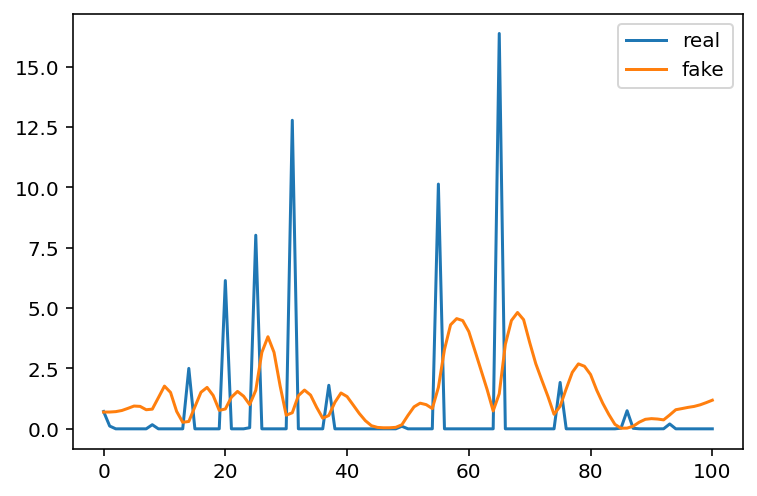

In [98]:
plt.figure()
plt.plot(model_notes.c_losses[:, 0], label='real')
plt.plot(model_notes.c_losses[:, 1], label='fake')
plt.legend()
plt.show()

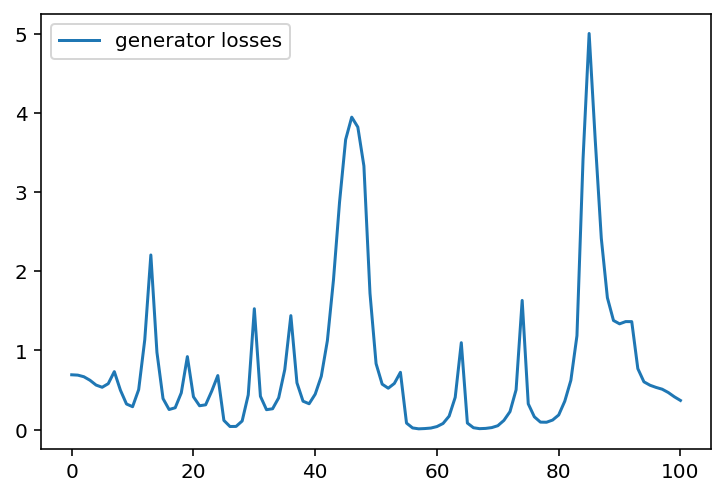

In [99]:
plt.figure()
plt.plot(model_notes.g_losses, label='generator losses')
plt.legend()
plt.show()

In [81]:
for epoch in model_notes.generated.keys():
    if epoch >= 0:
        for temperature in [0.0, 0.5, 0.9]:
            samples = [[inv_note_dictionary[x] for x in model_notes.generated[epoch][temperature]], 
                       [inv_dur_dictionary[x] for x in model_durations.generated[epoch][temperature]]]
            save_notes_and_durations(samples, f'output/gan/{epoch}_output_{temperature}_top')

### Use markov chain durations

In [82]:
from models.markov_chain import MarkovChain

In [83]:
markov_durations = MarkovChain()
markov_durations.fit_partial(durations_to_int)

In [84]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [85]:
for epoch in model_notes.generated.keys():
    if epoch > 0:
        for temperature in [0.0, 0.5, 0.9]:
            generated_notes = [inv_note_dictionary[x] for x in model_notes.generated[epoch][temperature]]
            generated_durations = [duration_dictionary[1/16]]
            for i in range(128):
                probas = [markov_durations.predict_proba_state_transition(generated_durations[i], duration_dictionary[x]) + 1e-6 for x in duration_dictionary]
                generated_durations.append(sample(probas, 0.9))
            save_notes_and_durations([generated_notes, [inv_dur_dictionary[x] for x in generated_durations]], f'output/gan/{epoch}_output_{temperature}_top')